# FBI Gun Data

The data comes from the FBI's National Instant Criminal Background Check System. The NICS is used by to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The data has been supplemented with state level data from census.gov.

The NICS data is found in one sheet of an .xlsx file. It contains the number of firearm checks by month, state, and type.
The U.S. census data is found in a .csv file. It contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.

Loading data:

In [428]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

gun_data = pd.read_csv('gun_data.csv')
US_Census_Data = pd.read_csv('US_Census_Data.csv')

In [429]:
gun_data.head(2)#check the data reading

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303


In [430]:
#summerize parts of data
gun_data['rentals_other'] = 0#fill up broken column
def sum_over_guns(gun_dataframe,column_index):
    '''
    Input:
        gun_dataframe: a pd.Dataframe contains 'xx_handgun', 'xx_long_gun', and 'xx_other' columns.
        column_index: the repeat common index "xx".
    Behavior:
        create new serie to by sum over 'xx_handgun', 'xx_long_gun', and 'xx_other' columns.
    Output:
        sum_over_guns: sum over data in 'xx_handgun', 'xx_long_gun', and 'xx_other'.
    '''
    handgun = column_index + '_handgun'
    long_gun = column_index + '_long_gun'
    other = column_index + '_other'
    sum_over_guns = gun_dataframe[handgun] + gun_dataframe[long_gun] + gun_dataframe[other]
    return sum_over_guns

gun_data_summerize = gun_data.fillna(0)
gun_data_summerize['prepawn'] = sum_over_guns(gun_data_summerize,'prepawn')
gun_data_summerize['redemption'] = sum_over_guns(gun_data_summerize,'redemption')
gun_data_summerize['returned'] = sum_over_guns(gun_data_summerize,'returned')
gun_data_summerize['rentals'] = sum_over_guns(gun_data_summerize,'rentals')
gun_data_summerize['private_sale'] = sum_over_guns(gun_data_summerize,'private_sale')
gun_data_summerize['return_to_seller'] = sum_over_guns(gun_data_summerize,'return_to_seller')

gun_data_summerize.head(2)#check data columns

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,return_to_seller_long_gun,return_to_seller_other,totals,rentals_other,prepawn,redemption,returned,rentals,private_sale,return_to_seller
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,3.0,32019,0,38.0,2641.0,0.0,0.0,28.0,3.0
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,6303,0,7.0,356.0,58.0,0.0,42.0,0.0


In [431]:
gun_data_summerize.shape#check the data scale

(12485, 34)

In [432]:
US_Census_Data.head(2)#check the data reading
US_Census_Data = US_Census_Data.fillna(0)

In [433]:
US_Census_Data.shape#check the data scale

(85, 52)

## Data refine and state grouping
To start analysis, we need to refine data. To analysis the following total items.
<ul>
    <li>prepawn and redemption</li>
    <li>returned and rentals</li>
    <li>private_sale and return_to_seller</li>
</ul>
By sum over corresponding handgun, long_gun, and other column.

In [434]:
#By state grouping data
state_vs_gun = gun_data_summerize.groupby(['state'], as_index = False).sum()
state_vs_gun.head(2)

,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,...,return_to_seller_long_gun,return_to_seller_other,totals,rentals_other,prepawn,redemption,returned,rentals,private_sale,return_to_seller
0,Alabama,1047441.0,749.0,2222037.0,2626029.0,39578.0,105230,32.0,4239.0,6343.0,...,12.0,6.0,6706079,0,10608.0,653892.0,0.0,1.0,450.0,32.0
1,Alaska,13352.0,22.0,434602.0,572174.0,15970.0,28904,19.0,1043.0,1463.0,...,6.0,1.0,1137643,0,2507.0,68682.0,950.0,0.0,451.0,10.0


We find there are no rentals_other column. We add it for convenient. 

In [435]:
state_vs_gun.columns

Index(['state', 'permit', 'permit_recheck', 'handgun', 'long_gun', 'other',
       'multiple', 'admin', 'prepawn_handgun', 'prepawn_long_gun',
       'prepawn_other', 'redemption_handgun', 'redemption_long_gun',
       'redemption_other', 'returned_handgun', 'returned_long_gun',
       'returned_other', 'rentals_handgun', 'rentals_long_gun',
       'private_sale_handgun', 'private_sale_long_gun', 'private_sale_other',
       'return_to_seller_handgun', 'return_to_seller_long_gun',
       'return_to_seller_other', 'totals', 'rentals_other', 'prepawn',
       'redemption', 'returned', 'rentals', 'private_sale',
       'return_to_seller'],
      dtype='object')

## Which states have had the highest growth in gun registrations?
Check the distribution of gun v.s state. We may find which state got most of guns.

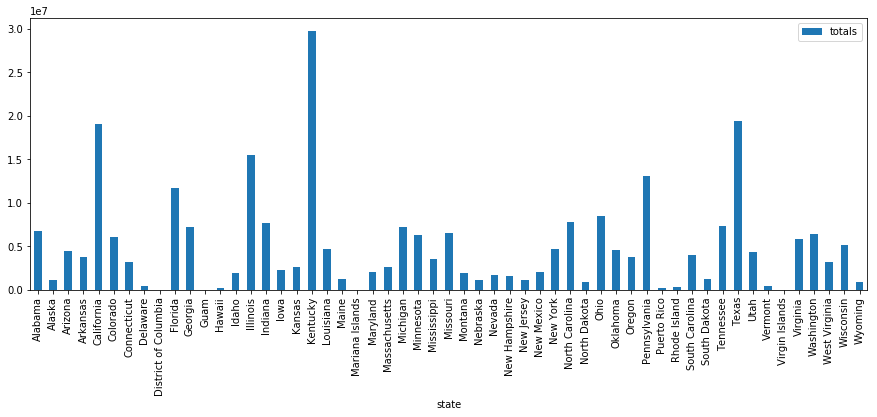

In [436]:
key_index = ['state', 'totals']
state_vs_gun_total = state_vs_gun.loc[:,key_index]
state_vs_gun_total.plot(x='state',kind='bar', figsize=(15,5))
#maybe we can modify y axis.

To simplify the data, we select top 5 states to analysis. First, we check number of guns by time variation.

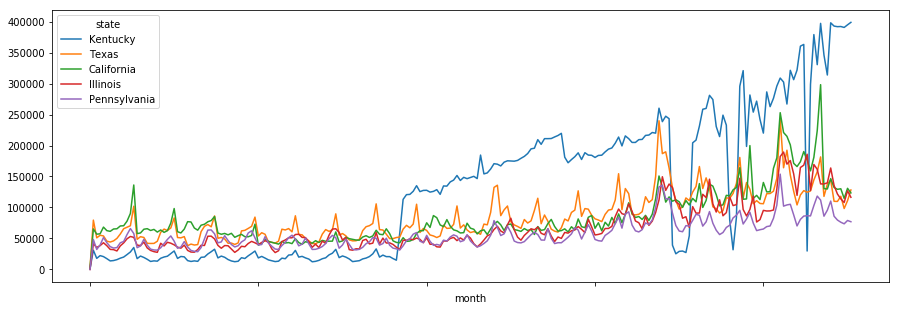

In [437]:
#select top 5 state.
totals_sort = state_vs_gun.sort_values('totals',ascending=False)
top_5_totals_gun_state = totals_sort.iloc[0:5,0]
#plot top 5 state month vs total guns.
gun_data_month_state = gun_data.groupby(['month','state'], as_index = False)
time_vs_totals_gun = gun_data_month_state.sum()
time_vs_totals_gun_reshape = time_vs_totals_gun.pivot(index='month', columns='state', values='totals')
time_vs_totals_gun_reshape.loc[:,top_5_totals_gun_state].plot(kind='line', figsize=(15,5))

It is abnormal trend up to Kentucky. To check what distribution of Kentucky.

In [438]:
gun_data_summerize.columns

Index(['month', 'state', 'permit', 'permit_recheck', 'handgun', 'long_gun',
       'other', 'multiple', 'admin', 'prepawn_handgun', 'prepawn_long_gun',
       'prepawn_other', 'redemption_handgun', 'redemption_long_gun',
       'redemption_other', 'returned_handgun', 'returned_long_gun',
       'returned_other', 'rentals_handgun', 'rentals_long_gun',
       'private_sale_handgun', 'private_sale_long_gun', 'private_sale_other',
       'return_to_seller_handgun', 'return_to_seller_long_gun',
       'return_to_seller_other', 'totals', 'rentals_other', 'prepawn',
       'redemption', 'returned', 'rentals', 'private_sale',
       'return_to_seller'],
      dtype='object')

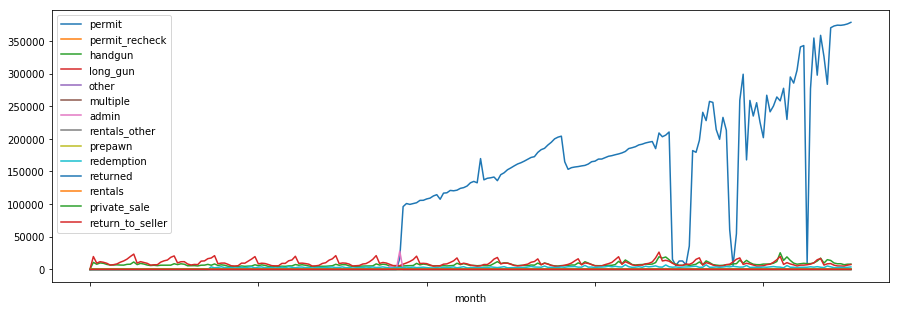

In [600]:
#dorp unnecessary columns
drop_columns = ['prepawn_handgun', 'prepawn_long_gun', 'prepawn_other', 'redemption_handgun', 
                'redemption_long_gun','redemption_other', 'returned_handgun', 'returned_long_gun',
                'returned_other', 'rentals_handgun', 'rentals_long_gun','private_sale_handgun', 
                'private_sale_long_gun', 'private_sale_other','return_to_seller_handgun', 
                'return_to_seller_long_gun','return_to_seller_other','totals']
gun_data_drop = gun_data_summerize.drop(drop_columns, axis=1)
gun_data_drop_by_month = gun_data_drop.sort_values(by='month')
gun_data_drop_by_month.loc[gun_data['state'] == 'Kentucky'].plot(kind='line', x='month', figsize=(15,5))

**The trend chart shows that "permit" almost dominates the number of guns in Kentucky, i.e. the highest registration rate.** 

## What is the overall trend of gun purchases?
To check this part, we remove 'permit','permit_recheck' first.

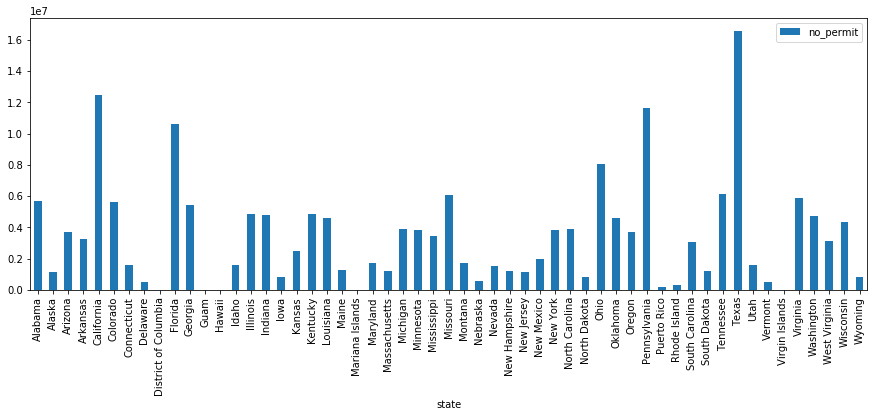

In [443]:
#total - permit - permit_recheck. 
state_vs_gun['no_permit'] = state_vs_gun['totals'] - state_vs_gun['permit'] - state_vs_gun['permit_recheck']
no_permit_index = ['state', 'no_permit']
state_vs_gun_no_permit= state_vs_gun.loc[:,no_permit_index]
state_vs_gun_no_permit.plot(x='state',kind='bar', figsize=(15,5))

It shows that Texas is the newest champion. We check the gun distribution of Texas.

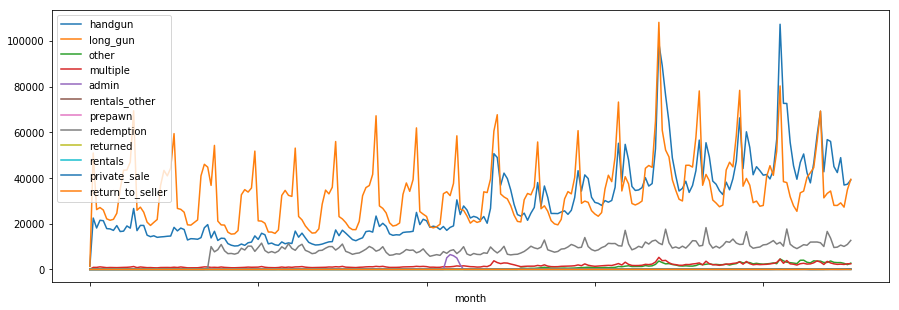

In [601]:
gun_data_drop_by_month_no_permit = gun_data_drop_by_month.drop(['permit','permit_recheck'], axis=1)
gun_data_drop_by_month_no_permit.loc[gun_data['state'] == 'Texas'].plot(kind='line', x='month', figsize=(15,5))

This Texas trend chart shows that **the gun purchases of handgun and long gun is changing periodic**. 
## What is the period of number of guns increase in Texas?
Since the number of handgun and long gun dominate the trend chart. We may as what period of the time. To check it, we isolate the handgun and long gun column.

In [605]:
#Extract Texas handgun and long_gun data
gun_dominate_columns = 
Time_vs_Texas_gun = gun_data_drop_by_month_no_permit.loc[gun_data['state'] == 'Texas',['month','handgun','long_gun']]
Time_vs_Texas_gun.head(3)

,month,handgun,long_gun
12476,1998-11,1384.0,1349.0
12421,1998-12,22478.0,50899.0
12366,1999-01,18123.0,26179.0


Since month column is string, it hard to calculate. We need to label a new index.

In [589]:
#Extract Texas handgun and long_gun data
Time_vs_Texas_hand_and_long_gun = gun_data_drop_by_month_no_permit[gun_data.state == 'Texas'].loc[:,['month','handgun','long_gun']]
#sperate to numpy array
order = 10**5
handgun_and_time = np.array(Time_vs_Texas_hand_and_long_gun['handgun'])/order
long_gun_and_time = np.array(Time_vs_Texas_hand_and_long_gun['long_gun'])/order
#Do FFT find max month frequency.
handgun_frqency = np.fft.fft(np.exp(2j * np.pi * handgun_and_time))
long_gun_frqency = np.fft.fft(np.exp(2j * np.pi * long_gun_and_time))

/Users/xch1/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [593]:
gun_frqency = pd.DataFrame()
gun_frqency['handgun_frqency'] = np.absolute(handgun_frqency)
gun_frqency['long_gun_frqency'] = np.absolute(long_gun_frqency)
N = len(gun_frqency)
trivial_frequency_region = 3
gun_frqency['frequncy'] = np.arange(N)
gun_frqency_refine = gun_frqency.loc[trivial_frequency_region:N-trivial_frequency_range]

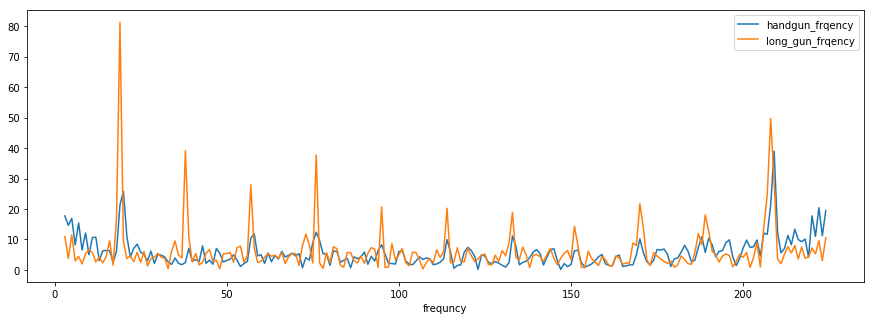

In [594]:
gun_frqency_refine.plot(kind='line', x='frequncy', figsize=(15,5))

## What census data is most associated with high gun per capita?


In [529]:
gun_frq['lg_frq'].argmax()

/Users/xch1/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  if __name__ == '__main__':


79